<a href="https://colab.research.google.com/github/moriyad12/Clustering-Algorithms/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
from google.colab import drive
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from scipy.sparse import csr_matrix
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors
import zipfile
from sklearn.cluster import SpectralClustering
import warnings

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#Reading Data

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/daily+and+sports+activities.zip', 'r') as zip_ref:
    zip_ref.extractall('activities')

In [ ]:
import numpy as np

def read_data():
    # Initialize lists to store data and labels
    training_data = []
    testing_data = []
    training_labels = []
    testing_labels = []
    mean_training_data = []
    mean_testing_data = []

    # Loop through activity IDs (1 to 19)
    for i in range(1, 20):
        # Loop through participant IDs (1 to 8)
        for j in range(1, 9):
            # Loop through session IDs (1 to 60)
            for h in range(1, 61):
                # Construct file path
                file_path = f"activities/data/a{i:02}/p{j}/s{h:02}.txt"

                # Load matrix data from file
                matrix_data = np.loadtxt(file_path, delimiter=',')

                # Calculate mean of matrix data along rows (axis=0)
                mean_matrix_data = np.mean(matrix_data, axis=0)

                # Flatten matrix data into a vector
                flatten_vector = [pixel for row in matrix_data for pixel in row]

                # Assign data and labels to training or testing sets based on session ID
                if h < 49:  # Use sessions 1 to 48 for training, the rest for testing
                    training_data.append(flatten_vector)
                    mean_training_data.append(mean_matrix_data)
                    training_labels.append(i)
                else:
                    testing_data.append(flatten_vector)
                    mean_testing_data.append(mean_matrix_data)
                    testing_labels.append(i)

    # Convert lists to numpy arrays and return
    return np.array(training_data), np.array(training_labels), np.array(testing_data), np.array(
        testing_labels), np.array(mean_training_data), np.array(mean_testing_data)

#Reducing Data

In [ ]:
def reduce_dimensionality(training_data, testing_data, n_components):
    # Initialize PCA with specified number of components
    pca = PCA(n_components=n_components)

    # Fit PCA to training data and transform both training and testing data
    reduced_training_data = pca.fit_transform(training_data)
    reduced_testing_data = pca.transform(testing_data)

    # Return reduced training and testing data
    return reduced_training_data, reduced_testing_data

In [ ]:
training_data, training_labels, testing_data, testing_labels, mean_training_data, mean_testing_data = read_data()
reduced_training_data, reduced_testing_data = reduce_dimensionality(training_data, testing_data, 45)

#Kmeans


In [ ]:
def Kmeans_fit(data, k=1, iterations=1000, repeat=10):
    # Define a helper function for K-means clustering
    def Kmeans(data, k, iterations):
        # Initialize cluster centers randomly
        centers = data[np.random.choice(len(data), k, replace=False)]

        # Iterate until convergence or maximum number of iterations
        for _ in range(iterations):
            # Assign each data point to the nearest cluster center
            labels = np.argmin(np.linalg.norm(data[:, None] - centers, axis=2), axis=1)

            # Update cluster centers based on the mean of points assigned to each cluster
            new_centers = np.array([np.mean(data[labels == i], axis=0) for i in range(k)])

            # Check for convergence
            if np.allclose(centers, new_centers):
                break

            # Update cluster centers
            centers = new_centers

        # Return the final cluster centers and labels
        return centers, labels

    # Initialize variables to store the best clustering result
    best_error = float('inf')
    best_centers = None
    best_labels = None

    # Repeat clustering process multiple times to find the best result
    for _ in range(repeat):
        # Perform K-means clustering
        centers, labels = Kmeans(data, k, iterations)

        # Calculate error (sum of distances between points and their nearest cluster centers)
        error = np.sum(np.linalg.norm(data - centers[labels], axis=1))

        # Update the best result if the current result has lower error
        if error < best_error:
            best_error = error
            best_centers = centers
            best_labels = labels

    # Return the best cluster centers and labels
    return best_centers, best_labels

In [ ]:
def Kmeans_predict(data, centers):
    return np.argmin(np.linalg.norm(data[:, None] - centers, axis=2), axis=1)

In [ ]:
Kmeans_methoud1_test = []
Kmeans_methoud2_test = []
Kmeans_methoud1_training = []
Kmeans_methoud2_training = []
ks = [8, 13, 19, 28, 38]

# first method:
for k in ks:
    centroids, labels = Kmeans_fit(mean_training_data, k)
    y_pred = Kmeans_predict(mean_testing_data, centroids)
    Kmeans_methoud1_test.append(y_pred)
    Kmeans_methoud1_training.append(labels)

# second method:
for k in ks:
    centroids, labels = Kmeans_fit(reduced_training_data, k)
    y_pred = Kmeans_predict(reduced_testing_data, centroids)
    Kmeans_methoud2_test.append(y_pred)
    Kmeans_methoud2_training.append(labels)

# Spectral Clustering

In [ ]:
def spectral_clustering(data, gamma, n_clusters):
    # Compute affinity matrix using radial basis function kernel
    affinity_matrix = rbf_kernel(data, gamma=gamma)

    # Convert affinity matrix to a sparse matrix
    affinity_matrix = csr_matrix(affinity_matrix)

    # Compute degree matrix
    degree_matrix = np.diag(np.sum(affinity_matrix, axis=1))

    # Compute Laplacian matrix
    laplacian_matrix = degree_matrix - affinity_matrix

    # Compute the eigenvectors and eigenvalues of the Laplacian matrix
    eigenvalues, eigenvectors = np.linalg.eig(laplacian_matrix)
    eigenvectors = np.real(eigenvectors)

    # Sort eigenvalues and select eigenvectors corresponding to the smallest eigenvalues
    idx = np.argsort(eigenvalues)[1:n_clusters]  # Exclude the first eigenvector (all ones)
    selected_eigenvectors = eigenvectors[:, idx]

    # Normalize selected eigenvectors
    norm = np.linalg.norm(selected_eigenvectors, axis=1, keepdims=True)
    normalized_eigenvectors = selected_eigenvectors / norm

    # Apply K-means clustering on the normalized eigenvectors
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(np.asarray(normalized_eigenvectors))

    return cluster_labels

# usage:
spectral_clustering_labels_1 = spectral_clustering(reduced_testing_data, 0.0001,  n_clusters=19)
spectral_clustering_labels_2 = spectral_clustering(mean_testing_data, 0.0001,  n_clusters=19)

In [ ]:
# Searching for optimal gamma
for gamma in [1, 5, 10, 20, 0.1, 0.01, 0.001, 0.0001]:
  spectral_clustering_labels_1 = spectral_clustering(reduced_testing_data, gamma, n_clusters=19)
  spectral_clustering_labels_2 = spectral_clustering(mean_testing_data, gamma,  n_clusters=19)
  spectral_purity = purity(spectral_clustering_labels_1, testing_labels)
  spectral_entropy = entropy(spectral_clustering_labels_1, testing_labels)
  spectral_F = F_measure(spectral_clustering_labels_1, testing_labels)
  spectral_recall = recall(spectral_clustering_labels_1, testing_labels)

  spectral_purity_2 = purity(spectral_clustering_labels_2, testing_labels)
  spectral_entropy_2 = entropy(spectral_clustering_labels_2, testing_labels)
  spectral_F_2 = F_measure(spectral_clustering_labels_2, testing_labels)
  spectral_recall_2 = recall(spectral_clustering_labels_2, testing_labels)

  print("*" * 10 + " Spectral Clustering Method 1 " + "*" * 10)
  print("gamma :" , gamma, "\n")
  print("purity:" , spectral_purity)
  print("entropy:" , spectral_entropy)
  print("F1:" , spectral_F)
  print("recall: ", spectral_recall)

  print("*" * 10 + " Spectral Clustering Method 2 - Means " + "*" * 10)
  print("gamma :" , gamma, "\n")
  print("purity:" , spectral_purity_2)
  print("entropy:" , spectral_entropy_2)
  print("F1:" , spectral_F_2)
  print("recall: ", spectral_recall_2)
  print("\n\n")

  # gamma 0.0001 is best with spectral 1
  # gamma 0.001 is best with spectral 2

********** Spectral Clustering Method 1 **********
gamma : 1 

purity: 0.17214912280701755
entropy: 3.630940366584686
F1: 0.21500220952337945
recall:  0.8753336700093788
********** Spectral Clustering Method 2 - Means **********
gamma : 1 

purity: 0.17763157894736842
entropy: 3.626243350606965
F1: 0.22472848788638267
recall:  0.7222222222222222



********** Spectral Clustering Method 1 **********
gamma : 5 

purity: 0.14144736842105263
entropy: 3.817926675311832
F1: 0.16672441638079186
recall:  0.5991649269311065
********** Spectral Clustering Method 2 - Means **********
gamma : 5 

purity: 0.17763157894736842
entropy: 3.6312249471387603
F1: 0.22585541868856546
recall:  0.9246194135577213



********** Spectral Clustering Method 1 **********
gamma : 10 

purity: 0.12609649122807018
entropy: 3.901431113159524
F1: 0.14111392438179432
recall:  0.7104072398190046
********** Spectral Clustering Method 2 - Means **********
gamma : 10 

purity: 0.17763157894736842
entropy: 3.631224947138760

#ُEvaluation

## Precision





In [ ]:
def purity(labels_pred, labels_true):
    # Create a dictionary to store indices of each cluster
    cluster_indices = {}

    # Iterate over each data point's predicted label and index
    for idx, label in enumerate(labels_pred):
        # Add the index to the list corresponding to the predicted label
        cluster_indices.setdefault(label, []).append(idx)

    # Calculate purity by summing the maximum count of true labels within each cluster
    purity = sum(np.max(np.bincount([labels_true[i] for i in cluster])) for cluster in cluster_indices.values())

    # Normalize by the total number of data points
    return purity / len(labels_true)

## Recall


In [ ]:
def recall(labels_pred, labels_true):
    # Initialize dictionaries to store counts of true labels predicted by each cluster and vice versa
    cluster_counts_pred = {label: np.zeros(len(labels_true), dtype=int) for label in labels_pred}
    cluster_counts_true = {label: np.zeros(len(labels_pred), dtype=int) for label in labels_true}

    # Populate cluster counts
    for idx, label_true in enumerate(labels_true):
        label_pred = labels_pred[idx]
        cluster_counts_pred[label_pred][label_true] += 1
        cluster_counts_true[label_true][label_pred] += 1

    # Calculate True Positives (TP) and False Negatives (FN)
    TP = 0
    FN = 0
    for label_pred in labels_pred:
        # Check if label_pred exists in both dictionaries
        if label_pred in cluster_counts_pred and label_pred in cluster_counts_true:
            # Iterate over corresponding counts of true labels for the current predicted label
            for count_pred, count_true in zip(cluster_counts_pred[label_pred], cluster_counts_true[label_pred]):
                TP += (count_pred * (count_pred - 1)) // 2  # Compute TP using combination formula
                FN += count_pred * count_true  # Accumulate FN counts

    # Calculate recall value
    recall_value = TP / (TP + FN) if TP + FN > 0 else 0

    return recall_value

## F1 score





In [ ]:
def F_measure(labels_pred, labels_true):
    # Initialize F-measure
    F = 0

    # Compute the count of each true label
    true_counts = np.bincount(labels_true)

    # Iterate over unique predicted labels
    for pred_label in np.unique(labels_pred):
        # Get indices of data points with the current predicted label
        cluster_indices = np.where(labels_pred == pred_label)[0]

        # Get true labels of data points in the current cluster
        true_cluster_labels = labels_true[cluster_indices]

        # Compute the count of each true label within the current cluster
        true_cluster_counts = np.bincount(true_cluster_labels)

        # Find the maximum count of true labels within the current cluster
        max_true_count = np.max(true_cluster_counts)

        # Compute the size of the current cluster
        cluster_size = len(cluster_indices)

        # Compute precision: maximum count of true labels within the current cluster divided by cluster size
        precision = max_true_count / cluster_size

        # Compute recall: maximum count of true labels within the current cluster divided by the count of the true label with the maximum count
        recall = max_true_count / true_counts[np.argmax(true_cluster_counts)]

        # Compute F-measure using precision and recall
        F += 2 * (precision * recall) / (precision + recall)

    # Normalize F-measure by the number of unique predicted labels
    return F / len(np.unique(labels_pred))

## Conditional Entropy

In [ ]:
def entropy(labels_pred, labels_true):
    entropy = 0

    # Iterate over each unique predicted label
    for cluster_label in np.unique(labels_pred):
        # Get indices of data points with the current predicted label
        cluster_indices = np.where(labels_pred == cluster_label)[0]

        # Get true labels of data points in the current cluster
        true_labels_in_cluster = labels_true[cluster_indices]

        # Compute the size of the current cluster
        cluster_size = len(cluster_indices)

        cluster_entropy = 0

        # Iterate over each unique true label within the current cluster
        for label in np.unique(true_labels_in_cluster):
            # Compute the count of occurrences of the current true label within the current cluster
            label_count = np.sum(true_labels_in_cluster == label)

            # Compute the proportion of the current true label within the current cluster
            proportion = label_count / cluster_size

            # Compute the contribution of the current true label to the cluster entropy
            cluster_entropy += -proportion * np.log2(proportion)

        # Update the overall entropy by adding the contribution of the current cluster
        entropy += cluster_entropy * cluster_size / len(labels_true)

    # Return the normalized entropy
    return entropy

In [ ]:
purities = []
recalls = []
entropies = []
F1s = []
def evaluate(predicted_labels, true_labels):
    # Clear lists before each call
    purities.clear()
    recalls.clear()
    entropies.clear()
    F1s.clear()

    for i, k in enumerate(ks):
        purities.append(purity(predicted_labels[i], true_labels))
        recalls.append(recall(predicted_labels[i], true_labels,k))
        entropies.append(entropy(predicted_labels[i], true_labels))
        F1s.append(F_measure(predicted_labels[i], true_labels))
        print(f"K={k}:")
        print(f"purity: {purities[-1]}")
        print(f"Recall: {recalls[-1]}")
        print(f"entropy: {entropies[-1]}")
        print(f"F1: {F1s[-1]}")
        print()

    plt.figure(figsize=(10, 10))
    # Plot Purity
    plt.subplot(2, 2, 1)
    plt.plot(ks, purities)
    plt.xlabel('K')
    plt.ylabel('Purity')
    plt.title('Purity')

    # Plot Entropy
    plt.subplot(2, 2, 2)
    plt.plot(ks, entropies)
    plt.xlabel('K')
    plt.ylabel('Entropy')
    plt.title('Entropy')

    # Plot F1
    plt.subplot(2, 2, 3)
    plt.plot(ks, F1s)
    plt.xlabel('K')
    plt.ylabel('F1 Score')
    plt.title('F1 Score')

    # plot Recall
    plt.subplot(2, 2, 4)
    plt.plot(ks, recalls)
    plt.xlabel('K')
    plt.ylabel('Recall')
    plt.title('Recall')

    plt.tight_layout()
    plt.show()


**********Kmeans**********
First method: training data
K=8:
purity: 0.3824013157894737
Recall: 0.7311349113645733
entropy: 2.312000374646418
F1: 0.6752976190361115

K=13:
purity: 0.4518914473684211
Recall: 0.5016110977509046
entropy: 2.069270393377754
F1: 0.5666354809002827

K=19:
purity: 0.47820723684210525
Recall: 0.38066425037790297
entropy: 1.8811816131430537
F1: 0.48947949965173143

K=28:
purity: 0.5341282894736842
Recall: 0.3481774769822729
entropy: 1.6261195710669345
F1: 0.41713276948799566

K=38:
purity: 0.5634594298245614
Recall: 0.30988473959049057
entropy: 1.5434226339851596
F1: 0.35014318828995283



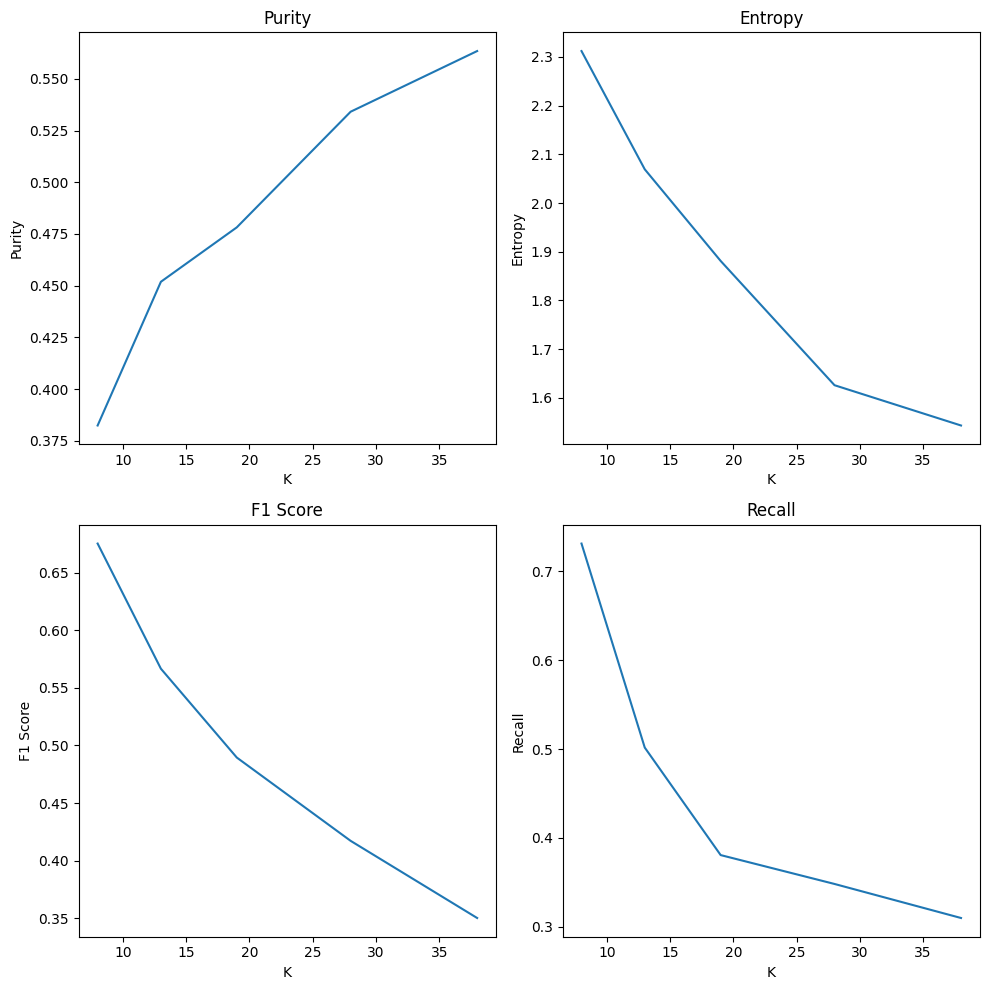

In [ ]:
print("*" * 10 + "Kmeans" + "*" * 10)
print("First method: training data")
evaluate(Kmeans_methoud1_training, training_labels)

First method: testing data
K=8:
purity: 0.37609649122807015
Recall: 0.7339335180055402
entropy: 2.3228819946654906
F1: 0.6672218414292803

K=13:
purity: 0.44024122807017546
Recall: 0.5011542012927055
entropy: 2.0430526911205837
F1: 0.5553367135069086

K=19:
purity: 0.46655701754385964
Recall: 0.3746421975992613
entropy: 1.8443252019801069
F1: 0.48030652884410957

K=28:
purity: 0.5241228070175439
Recall: 0.3393005540166205
entropy: 1.6372342937224722
F1: 0.42315263179116896

K=38:
purity: 0.5696271929824561
Recall: 0.31481994459833795
entropy: 1.484607899322309
F1: 0.36157559224416974



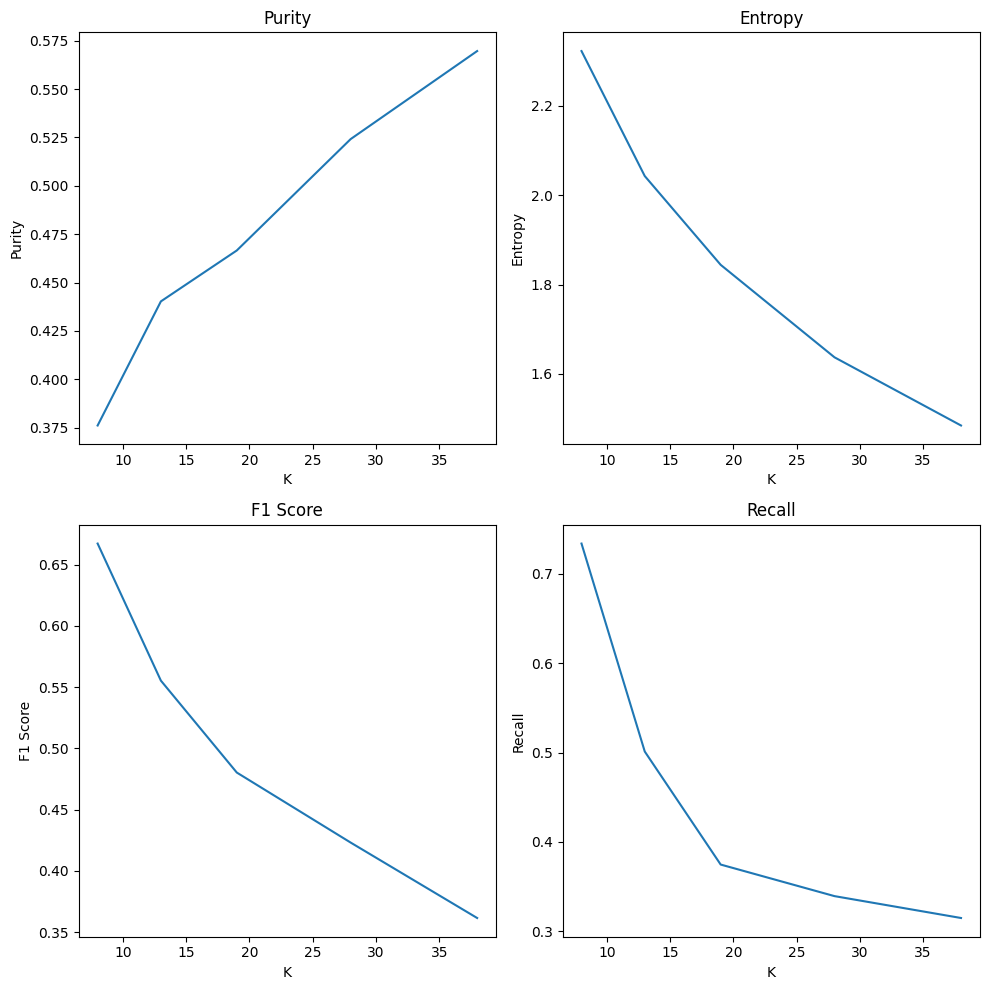

In [ ]:
print("First method: testing data")
evaluate(Kmeans_methoud1_test, testing_labels)

Second method: training data
K=8:
purity: 0.3555372807017544
Recall: 0.7608611321057213
entropy: 2.317948079290602
F1: 0.6178636747955261

K=13:
purity: 0.4276315789473684
Recall: 0.6303078191562457
entropy: 2.150871839831581
F1: 0.5428228547143745

K=19:
purity: 0.47738486842105265
Recall: 0.4657432378269433
entropy: 1.9192612118925994
F1: 0.4610123759449887

K=28:
purity: 0.4916392543859649
Recall: 0.3738534079978013
entropy: 1.8839351652672234
F1: 0.38013420098472717

K=38:
purity: 0.5570175438596491
Recall: 0.2914576748660162
entropy: 1.6254479322677629
F1: 0.35973852686884616



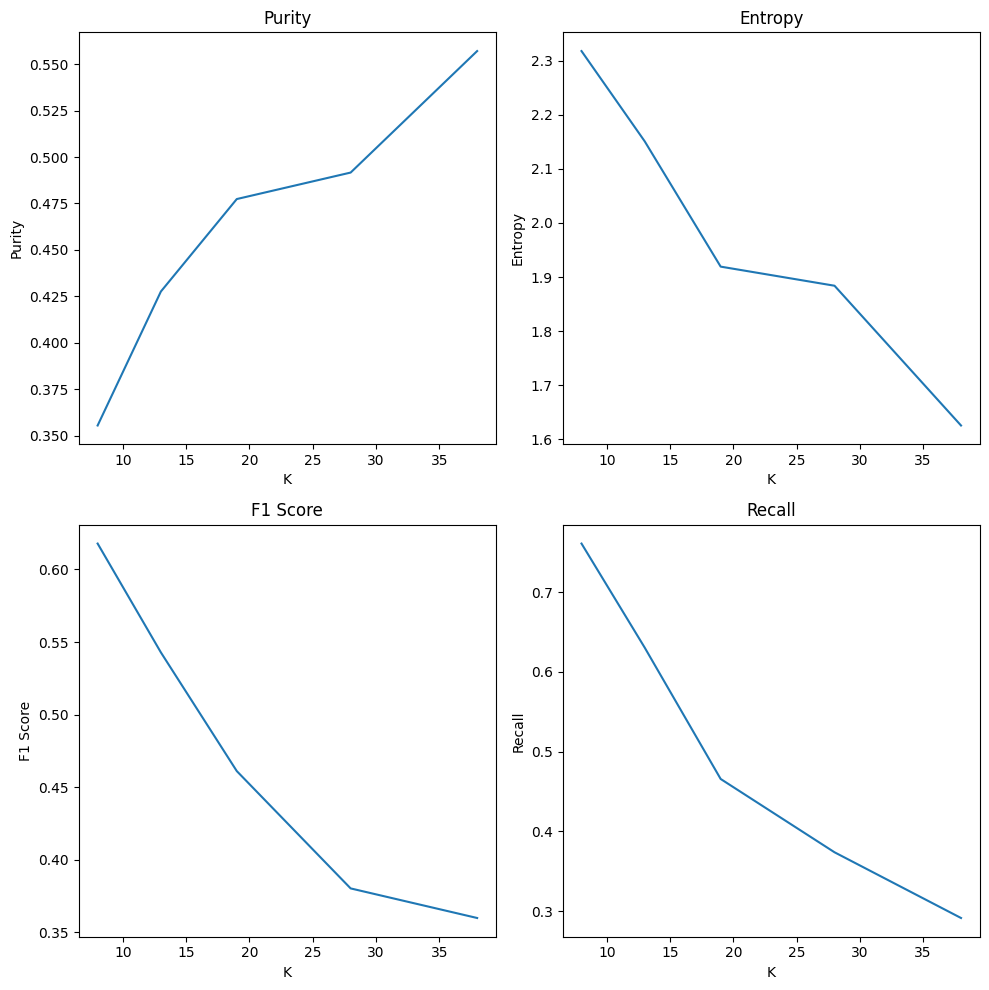

In [ ]:
print("Second method: training data")
evaluate(Kmeans_methoud2_training, training_labels)

Second method: testing data
K=8:
purity: 0.35471491228070173
Recall: 0.7660664819944598
entropy: 2.3237134368525476
F1: 0.6168666536587071

K=13:
purity: 0.42160087719298245
Recall: 0.6286357340720221
entropy: 2.1629979402044652
F1: 0.5355643567243147

K=19:
purity: 0.4616228070175439
Recall: 0.4537511542012927
entropy: 1.931918890355172
F1: 0.4487852875703184

K=28:
purity: 0.4824561403508772
Recall: 0.375207756232687
entropy: 1.8808705981957814
F1: 0.37219459986007714

K=38:
purity: 0.5455043859649122
Recall: 0.28460295475530933
entropy: 1.6687900091284842
F1: 0.35014212643779485



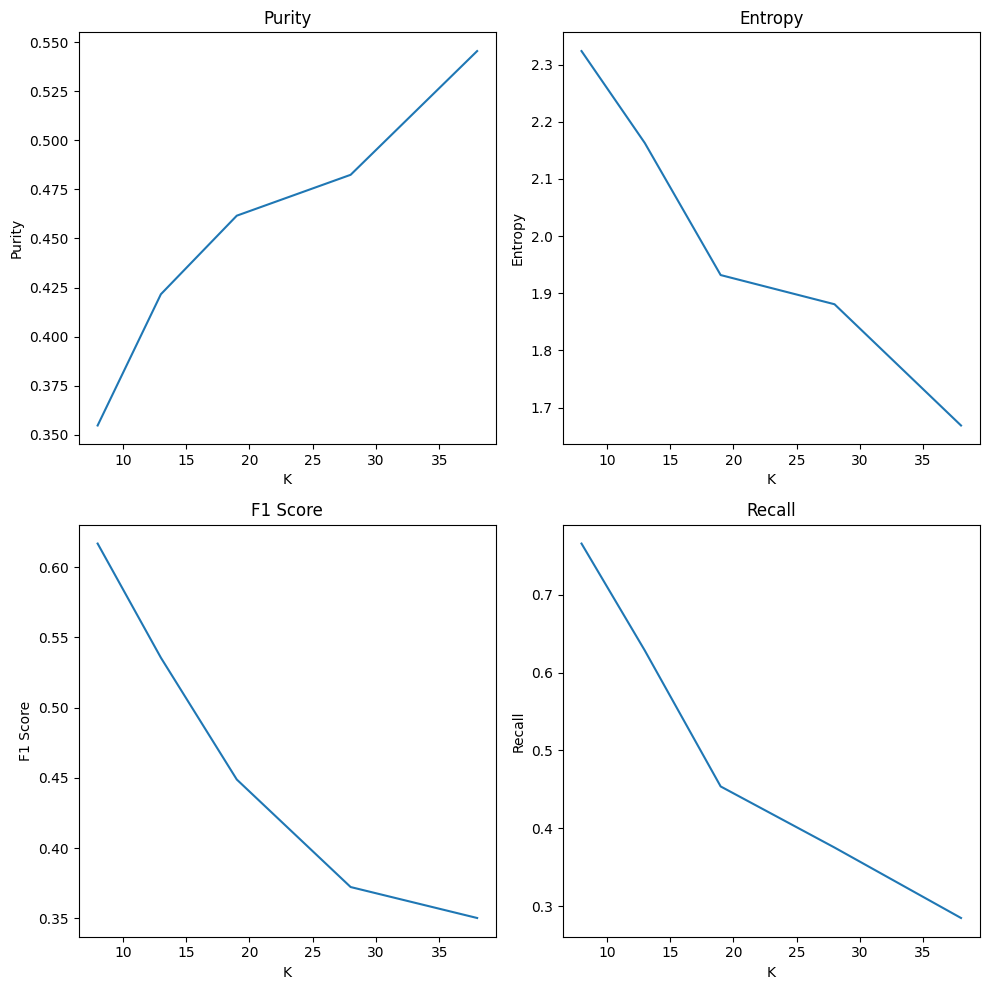

In [ ]:
print("Second method: testing data")
evaluate(Kmeans_methoud2_test, testing_labels)

## Comparison
1. Purity: Purity measures the extent to which clusters contain a single class. Higher purity values indicate better clustering performance in terms of class homogeneity within clusters. From the provided results, we observe that the purity values generally increase with increasing values of K for both methods. However, the purity values achieved by the second method tend to be slightly higher than those achieved by the first method for most K values.

2. Recall: Recall measures the ability of the clustering algorithm to find all the relevant instances of a class. Higher recall values indicate better clustering performance in terms of capturing all instances of each class. From the provided results, we observe that the recall values generally decrease with increasing values of K for both methods. Additionally, the recall values achieved by the first method tend to be slightly higher than those achieved by the second method for most K values.

3. Entropy: Entropy measures the uncertainty or disorder in the clustering assignments. Lower entropy values indicate better clustering performance in terms of separating different classes into distinct clusters. From the provided results, we observe that the entropy values generally decrease with increasing values of K for both methods. However, the entropy values achieved by the second method tend to be slightly lower than those achieved by the first method for most K values.

4. F1 Score: The F1 score is the harmonic mean of precision and recall, providing a balance between these two metrics. Higher F1 scores indicate better overall clustering performance. From the provided results, we observe that the F1 scores generally follow similar trends as the recall values for both methods.

Based on these observations, we can conclude that the second method (flattening all features together and then applying PCA for dimensionality reduction) tends to perform slightly better in terms of purity and entropy, while the first method (taking the mean of each column in each segment) achieves slightly higher recall values.

# Spectral Score

In [ ]:
spectral_purity = purity(spectral_clustering_labels_1, testing_labels)
spectral_entropy = entropy(spectral_clustering_labels_1, testing_labels)
spectral_F = F_measure(spectral_clustering_labels_1, testing_labels)
spectral_recall = recall(spectral_clustering_labels_1, testing_labels)

spectral_purity_2 = purity(spectral_clustering_labels_2, testing_labels)
spectral_entropy_2 = entropy(spectral_clustering_labels_2, testing_labels)
spectral_F_2 = F_measure(spectral_clustering_labels_2, testing_labels)
spectral_recall_2 = recall(spectral_clustering_labels_2, testing_labels)

print("*" * 10 + " Spectral Clustering Method 1 " + "*" * 10)
print("purity:" , spectral_purity)
print("entropy:" , spectral_entropy)
print("F1:" , spectral_F)
print("recall: ", spectral_recall)

print("\n\n")

print("*" * 10 + " Spectral Clustering Method 2 - Means " + "*" * 10)
print("purity:" , spectral_purity_2)
print("entropy:" , spectral_entropy_2)
print("F1:" , spectral_F_2)
print("recall: ", spectral_recall_2)

********** Spectral Clustering Method 1 **********
purity: 0.4621710526315789
entropy: 1.8494386570264658
F1: 0.4584407558672485
recall:  0.804727956714581



********** Spectral Clustering Method 2 - Means **********
purity: 0.48135964912280704
entropy: 1.8793530695519167
F1: 0.48737225452326677
recall:  0.7917866465728357


In [ ]:
purities_avg_1 = np.mean(purities)
recalls_avg_1 = np.mean(recalls)
entropies_avg_1 = np.mean(entropies)
F1s_avg_1 = np.mean(F1s)


purities_avg_2 = np.mean(purities)
recalls_avg_2 = np.mean(recalls)
entropies_avg_2 = np.mean(entropies)
F1s_avg_2 = np.mean(F1s)

# Comparison of Spectral Clustering with KMeans

********** Spectral Clustering Method 1 **********
purity: 0.44956140350877194
entropy: 1.8900525706728584
F1: 0.4519635159199907
recall:  0.8809055557736218
********** Spectral Clustering Method 2 - Means **********
purity: 0.45723684210526316
entropy: 1.9506725043975206
F1: 0.4677625531598726
recall:  0.5072458561402907
********** Kmeans Method 1  **********
purity: 0.4833333333333334
entropy: 1.8604000796746374
F1: 0.4910761424710424
recall: 0.8376188957820391
********** Kmeans Method 2 - Means **********
purity: 0.43673245614035083
entropy: 2.079548481597956
F1: 0.4373114765201488
recall: 0.8252181193226302


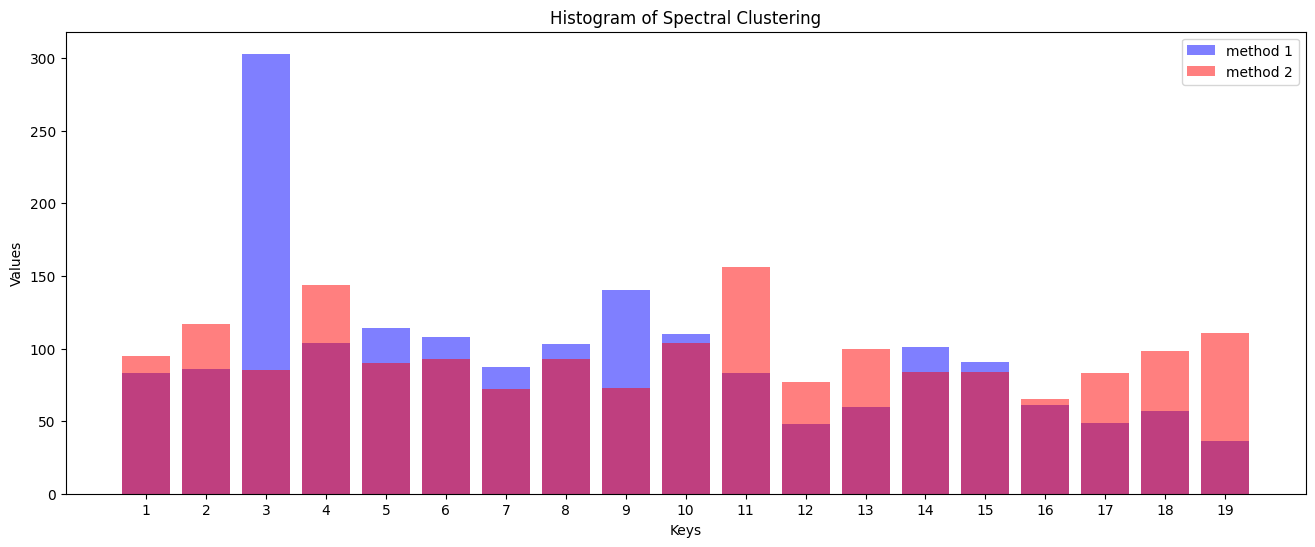

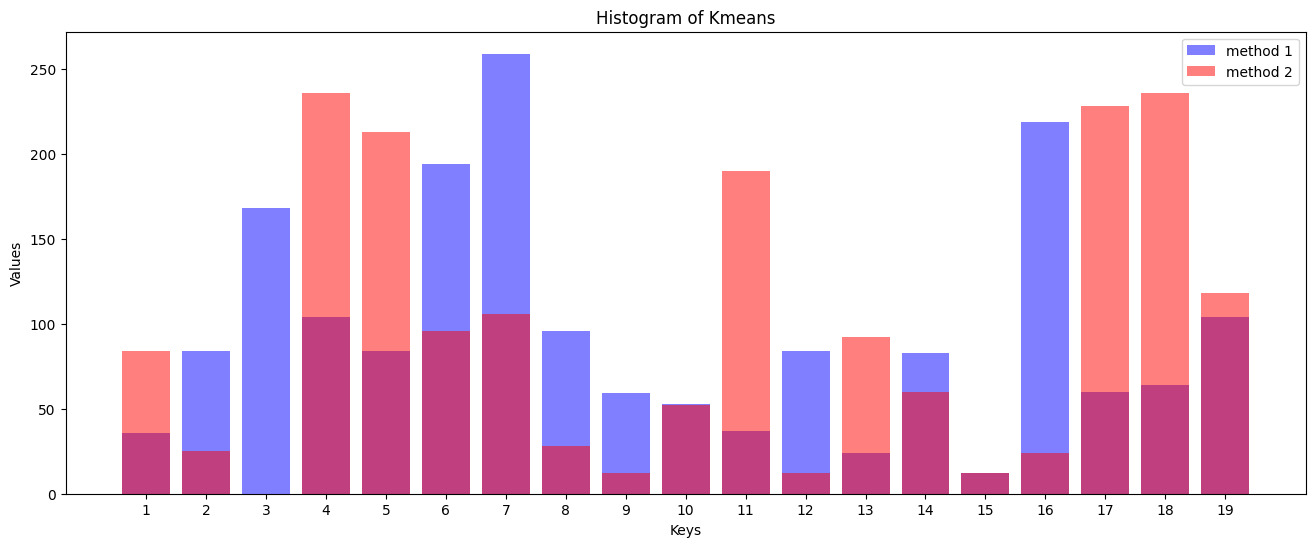

In [ ]:
# external measures

# method1 - Spectral
print("*" * 10 + " Spectral Clustering Method 1 " + "*" * 10)
print("purity:" , spectral_purity)
print("entropy:" , spectral_entropy)
print("F1:" , spectral_F)
print("recall: ", spectral_recall)

# method2 - Spectral
print("*" * 10 + " Spectral Clustering Method 2 - Means " + "*" * 10)
print("purity:" , spectral_purity_2)
print("entropy:" , spectral_entropy_2)
print("F1:" , spectral_F_2)
print("recall: ", spectral_recall_2)

# method 1 - Kmeans
print("*" * 10 + " Kmeans Method 1  " + "*" * 10)
print("purity:" , purities_avg_1)
print("entropy:", entropies_avg_1)
print("F1:" , F1s_avg_1)
print("recall:", recalls_avg_1)

# method 2 - Kmeans
print("*" * 10 + " Kmeans Method 2 - Means " + "*" * 10)
print("purity:" , purities_avg_2)
print("entropy:", entropies_avg_2)
print("F1:" , F1s_avg_2)
print("recall:", recalls_avg_2)


# number of activities per cluster
number_of_activities_per_cluster_spec1 = {str(i): None for i in range(1, 20)}
number_of_activities_per_cluster_spec2 = {str(i): None for i in range(1, 20)}
number_of_activities_per_cluster_kmeans1 = {str(i): None for i in range(1, 20)}
number_of_activities_per_cluster_kmean2 = {str(i): None for i in range(1, 20)}

for i in range(1, 20):
  number_of_activities_per_cluster_spec1[str(i)] = len(np.where(spectral_clustering_labels_1 + 1== i)[0])
  number_of_activities_per_cluster_spec2[str(i)] = len(np.where(spectral_clustering_labels_2 + 1 == i)[0])
  number_of_activities_per_cluster_kmeans1[str(i)] = len(np.where(Kmeans_methoud1_test[2] + 1== i)[0])
  number_of_activities_per_cluster_kmean2[str(i)] = len(np.where(Kmeans_methoud2_test[2] + 1== i)[0])

keys = [int(key) for key in number_of_activities_per_cluster_spec1.keys()]
values1 = [number_of_activities_per_cluster_spec1[str(key)] for key in sorted(keys)]
values2 = [number_of_activities_per_cluster_spec2[str(key)] for key in sorted(keys)]
values3 = [number_of_activities_per_cluster_kmeans1[str(key)] for key in sorted(keys)]
values4 = [number_of_activities_per_cluster_kmean2[str(key)] for key in sorted(keys)]

plt.figure(figsize=(16, 6))
plt.bar(keys, values1, color='blue', alpha=0.5, label='method 1')
plt.bar(keys, values2, color='red', alpha=0.5, label='method 2')
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Histogram of Spectral Clustering')
plt.xticks(keys)
plt.legend()
plt.show()

plt.figure(figsize=(16, 6))
plt.bar(keys, values3, color='blue', alpha=0.5, label='method 1')
plt.bar(keys, values4, color='red', alpha=0.5, label='method 2')
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Histogram of Kmeans')
plt.xticks(keys)
plt.legend()
plt.show()

#DBSCAN

In [ ]:
def DBSCAN(data, eps, min_samples):
    clusters = []
    n = len(data)
    visited = np.zeros(n)  # Create an array to track visited data points
    for i in range(n):
        if visited[i] == 0:  # Check if the data point has been visited
            visited[i] = 1  # Mark the data point as visited
            neighbours = find_neighbours(data, i, eps)  # Find neighbours of the current data point
            if len(neighbours) < min_samples:
                visited[i] = 2  # Mark the data point as noise if it doesn't have enough neighbours
            else:
                cluster = expand_cluster(i, data, neighbours, eps, min_samples, visited)  # Expand the cluster
                clusters.append(cluster)  # Add the cluster to the list of clusters
    return clusters

In [ ]:
def find_neighbours(data, index, eps):
    # Initialize an empty list to store the indices of neighbouring data points
    neighbours = []

    # Iterate over each data point in the dataset
    for i in range(len(data)):
        # Calculate the Euclidean distance between the current data point and the data point at index 'index'
        distance = np.linalg.norm(data[index] - data[i])

        # Check if the distance is less than the specified epsilon (eps)
        if distance < eps:
            # If the distance is less than eps, add the index of the data point to the list of neighbours
            neighbours.append(i)

    # Return the list of neighbouring data points
    return neighbours

In [ ]:
def expand_cluster(point, data, neighbours, eps, min_samples, visited):
    # Initialize an empty list to store the indices of data points in the cluster
    cluster = []

    # Add the current point to the cluster
    cluster.append(point)

    # Mark the current point as visited with a label '3'
    visited[point] = 3

    # Iterate over each neighbour of the current point
    for neighbour in neighbours:
        # Check if the neighbour has not been visited
        if visited[neighbour] == 0:
            # Mark the neighbour as visited with a label '1'
            visited[neighbour] = 1

            # Find new neighbours of the neighbour
            new_neighbours = find_neighbours(data, neighbour, eps)

            # Check if the neighbour has enough neighbours to be considered as a core point
            if len(new_neighbours) >= min_samples:
                # Extend the neighbours list with the new neighbours
                neighbours.extend(new_neighbours)

        # Check if the neighbour has not been added to the cluster yet
        if visited[neighbour] != 3:
            # Mark the neighbour as visited and add it to the cluster
            visited[neighbour] = 3
            cluster.append(neighbour)

    # Return the list of indices of data points in the cluster
    return cluster

In [ ]:
def predict_labels(testing_data, clusters):
    # Initialize an empty list to store predicted labels
    labels = []

    # Iterate over each sample in the testing data
    for sample in testing_data:
        # Initialize variables to store minimum distance and closest cluster label
        min_distance = float('inf')
        closest_cluster_label = -1

        # Iterate over each cluster and its points
        for cluster_label, cluster_points in enumerate(clusters):
            for cluster_point in cluster_points:
                # Compute the Euclidean distance between the current sample and the data point in the cluster
                distance = np.linalg.norm(sample - testing_data[cluster_point])

                # Update minimum distance and closest cluster label if a closer point is found
                if distance < min_distance:
                    min_distance = distance
                    closest_cluster_label = cluster_label

        # Append the predicted label to the list of labels
        labels.append(closest_cluster_label + 1)  # Add 1 to convert from zero-based index to one-based label

    # Return the list of predicted labels
    return labels

In [ ]:
def plot_and_print_comparison(dbscan_clustering_labels_1, dbscan_clustering_labels_2, testing_labels):
    # Calculate evaluation metrics for dbscan_clustering_labels_1
    dbscan_purity_1 = purity(dbscan_clustering_labels_1, testing_labels)
    dbscan_entropy_1 = entropy(dbscan_clustering_labels_1, testing_labels)
    dbscan_F_1 = F_measure(dbscan_clustering_labels_1, testing_labels)
    dbscan_recall_1 = recall(dbscan_clustering_labels_1, testing_labels)

    # Calculate evaluation metrics for dbscan_clustering_labels_2
    dbscan_purity_2 = purity(dbscan_clustering_labels_2, testing_labels)
    dbscan_entropy_2 = entropy(dbscan_clustering_labels_2, testing_labels)
    dbscan_F_2 = F_measure(dbscan_clustering_labels_2, testing_labels)
    dbscan_recall_2 = recall(dbscan_clustering_labels_2, testing_labels)

    # Print the values
    print("Metrics\t\tDBSCAN Clustering 1\tDBSCAN Clustering 2")
    print("-------------------------------------------------------")
    print(f"Purity:\t\t{dbscan_purity_1:.4f}\t\t\t{dbscan_purity_2:.4f}")
    print(f"Entropy:\t{dbscan_entropy_1:.4f}\t\t\t{dbscan_entropy_2:.4f}")
    print(f"F-measure:\t{dbscan_F_1:.4f}\t\t\t{dbscan_F_2:.4f}")
    print(f"Recall:\t\t{dbscan_recall_1:.4f}\t\t\t{dbscan_recall_2:.4f}")
    print("-------------------------------------------------------")

    # List of metric names
    metrics = ['Purity', 'Entropy', 'F-measure', 'Recall']

    # Values for dbscan_clustering_labels_1 and dbscan_clustering_labels_2
    values_1 = [dbscan_purity_1, dbscan_entropy_1, dbscan_F_1, dbscan_recall_1]
    values_2 = [dbscan_purity_2, dbscan_entropy_2, dbscan_F_2, dbscan_recall_2]

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot values for dbscan_clustering_labels_1
    ax.plot(metrics, values_1, marker='o', label='DBSCAN Clustering 1')

    # Plot values for dbscan_clustering_labels_2
    ax.plot(metrics, values_2, marker='o', label='DBSCAN Clustering 2')

    # Set plot title and labels
    ax.set_title('Comparison of Evaluation Metrics for DBSCAN Clustering')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')

    # Add a legend
    ax.legend()

    # Show the plot
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
clusters_1 = DBSCAN(reduced_testing_data, 40, 10)
dbscan_clustering_labels_1 = predict_labels(reduced_testing_data, clusters_1)

dbscan_purity_1 = purity(dbscan_clustering_labels_1, testing_labels)
dbscan_entropy_1 = entropy(dbscan_clustering_labels_1, testing_labels)
dbscan_F_1 = F_measure(dbscan_clustering_labels_1, testing_labels)
dbscan_recall_1 = recall(dbscan_clustering_labels_1, testing_labels)

In [ ]:
clusters_2 = DBSCAN(mean_testing_data, 2, 7)
dbscan_clustering_labels_2 = predict_labels(mean_testing_data, clusters_2)

dbscan_purity_2 = purity(dbscan_clustering_labels_2, testing_labels)
dbscan_entropy_2 = entropy(dbscan_clustering_labels_2, testing_labels)
dbscan_F_2 = F_measure(dbscan_clustering_labels_2, testing_labels)
dbscan_recall_2 = recall(dbscan_clustering_labels_2, testing_labels)

Metrics		DBSCAN Clustering 1	DBSCAN Clustering 2
-------------------------------------------------------
Purity:		0.3953			0.8251
Entropy:	2.2172			0.5836
F-measure:	0.2718			0.2277
Recall:		0.7676			0.9862
-------------------------------------------------------


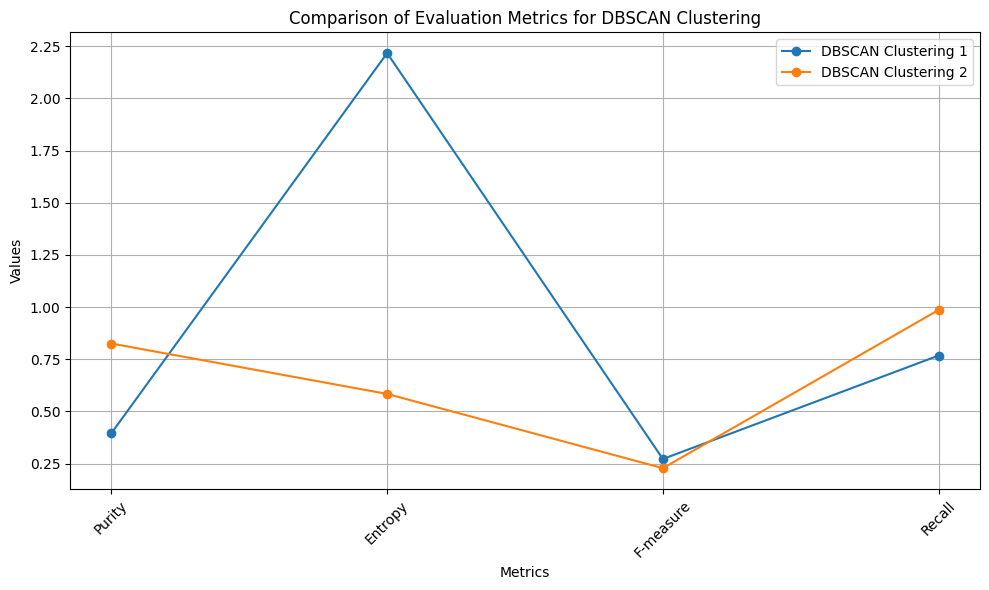

Number of clusters in first set :35
Number of clusters in second set :118


In [ ]:
# Call the function with your actual data
plot_and_print_comparison(dbscan_clustering_labels_1, dbscan_clustering_labels_2, testing_labels)
print(f"Number of clusters in first set :{len(clusters_1)}")
print(f"Number of clusters in second set :{len(clusters_2)}")

The provided values represent evaluation metrics for two different sets of clustering results. Here's a comment summarizing the comparison between the two sets:

The first set of clustering results exhibits lower purity, higher entropy, lower F-measure, and lower recall compared to the second set. These differences suggest that the clusters in the first set are less internally homogeneous (lower purity), more disorganized or dispersed (higher entropy), have lower overall accuracy (lower F-measure), and miss more true positive instances (lower recall) compared to the clusters in the second set.

Overall, the second set of clustering results appears to be more favorable based on these evaluation metrics, indicating a better quality of clustering compared to the first set.
I think the cause of that in the first set the diereence betwen points in same cluster is very big in some clusers and very samll in other clusters.

In [ ]:
def k_distance_plot(data, k):
    neighbours = NearestNeighbors(n_neighbors=k)
    neighbours.fit(data)
    distances, indices = neighbours.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]
    plt.plot(distances)
    plt.show()

###How to determine the two paramters?
the value of epslon is known giving the value of min_samples by ploting kth distane plot.
I made binary search on min_samble value to fet best evaluation  

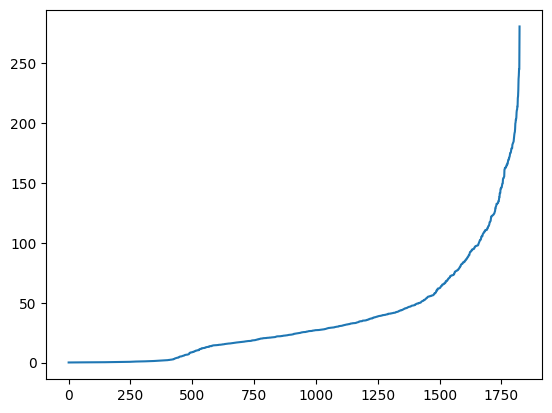

In [ ]:
k_distance_plot(reduced_testing_data, 10)

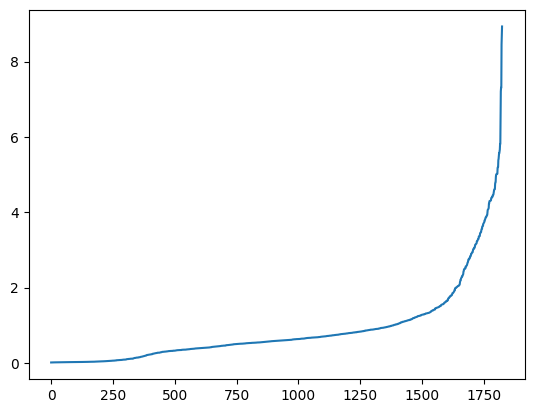

In [ ]:
k_distance_plot(mean_testing_data, 7)